# View Molecular Structure

In [8]:
import nglview as ng

# Create a combined view of protein and ligand
view = ng.NGLWidget()
view.add_structure(ng.FileStructure('../data/input/1aml.pdb'), name='Protein')
view.add_structure(ng.FileStructure('../data/input/DB00843.pdb'), name='Ligand')
view.center()
view

NGLWidget()

# Molecular Dynamics simulation using OpenMP and MPI

In [2]:
import os
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from mpi4py import MPI

class MDSimulation:
    def __init__(self, input_dir, thread_counts=[1, 2, 4, 8]):
        # Initialize MPI
        self.comm = MPI.COMM_WORLD
        self.rank = self.comm.Get_rank()
        self.size = self.comm.Get_size()
        
        self.input_dir = input_dir
        self.thread_counts = thread_counts
        self.results = {}
    

    def setup_md_parameters(self):
        """Create MD parameter files"""
        if self.rank == 0:
        # Energy minimization parameters
            em_mdp = """
                ; Energy minimization parameters
                integrator    = steep     ; Steepest descent energy minimization
                nsteps        = 50000     ; Maximum number of steps
                emtol         = 1000.0    ; Stop when max force < 1000 kJ/mol/nm
                emstep        = 0.01      ; Initial step-size
                nstlist       = 1         ; Frequency to update neighbor list
                cutoff-scheme = Verlet    ; Neighbor search method
                ns_type       = grid      ; Method to determine neighbor list
                coulombtype   = PME       ; Treatment of long-range electrostatic interactions
                rcoulomb      = 1.0       ; Short-range electrostatic cut-off
                rvdw          = 1.0       ; Short-range van der Waals cut-off
                pbc           = xyz       ; Periodic boundary conditions
                """
            # NVT equilibration parameters
            nvt_mdp = """
                ; NVT equilibration parameters
                integrator      = md        ; leap-frog integrator
                nsteps          = 50000     ; 100 ps
                dt              = 0.002     ; 2 fs
                nstxout-compressed = 5000   ; save coordinates every 10 ps

                ; Temperature coupling
                tcoupl          = V-rescale ; modified Berendsen thermostat
                tc-grps         = Protein Non-Protein ; coupling groups
                tau_t           = 0.1 0.1   ; time constant, in ps
                ref_t           = 300 300   ; reference temperature, one for each group, in K

                ; Pressure coupling is off
                pcoupl          = no        ; no pressure coupling in NVT

                ; Periodic boundary conditions
                pbc             = xyz       ; 3-D PBC

                ; Constraint algorithms
                constraints      = h-bonds  ; constrain H-bond lengths
                constraint_algorithm = lincs ; holonomic constraints

                ; Neighbor searching
                cutoff-scheme   = Verlet
                ns_type         = grid
                nstlist         = 10
                rcoulomb        = 1.0
                rvdw            = 1.0

                ; Electrostatics
                coulombtype     = PME      ; Particle Mesh Ewald for long-range electrostatics
                pme_order       = 4        ; cubic interpolation
                fourierspacing  = 0.16     ; grid spacing for FFT
                """
            # Production MD parameters
            md_mdp = """
                ; Production MD parameters
                integrator      = md        ; leap-frog integrator
                nsteps          = 500000    ; 1000 ps (1 ns)
                dt              = 0.002     ; 2 fs
                nstxout-compressed = 5000   ; save coordinates every 10 ps

                ; Temperature coupling
                tcoupl          = V-rescale ; modified Berendsen thermostat
                tc-grps         = Protein Non-Protein
                tau_t           = 0.1 0.1
                ref_t           = 300 300

                ; Pressure coupling
                pcoupl          = Parrinello-Rahman ; pressure coupling
                pcoupltype      = isotropic         ; uniform scaling of box vectors
                tau_p           = 2.0               ; time constant, in ps
                ref_p           = 1.0               ; reference pressure, in bar
                compressibility = 4.5e-5            ; isothermal compressibility of water

                ; Constraints
                constraints      = h-bonds
                constraint_algorithm = lincs

                ; Neighbor searching
                cutoff-scheme   = Verlet
                ns_type         = grid
                nstlist         = 10
                rcoulomb        = 1.0
                rvdw            = 1.0

                ; Electrostatics
                coulombtype     = PME
                pme_order       = 4
                fourierspacing  = 0.16
                """
            
            print(f"Parameters set up on rank {self.rank}")

        # Write parameter files
        with open(f"{self.input_dir}/em.mdp", 'w') as f:
            f.write(em_mdp)
        with open(f"{self.input_dir}/nvt.mdp", 'w') as f:
            f.write(nvt_mdp)
        with open(f"{self.input_dir}/md.mdp", 'w') as f:
            f.write(md_mdp)

        self.comm.Barrier()
        
    def run_md_simulation(self, threads):
        """Run MD simulation with MPI and OpenMP"""
        os.environ['OMP_NUM_THREADS'] = str(threads)
        timings = {}
        
        steps = ['em', 'nvt', 'md']
        
        for step in steps:
            # Generate tpr file only on rank 0
            if self.rank == 0:
                subprocess.run(['gmx_mpi', 'grompp', 
                              '-f', f'{self.input_dir}/{step}.mdp',
                              '-c', f'{self.input_dir}/solvated.gro',
                              '-p', f'{self.input_dir}/topol.top',
                              '-o', f'{step}.tpr'])
            
            # Wait for tpr file to be created
            self.comm.Barrier()
            
            # Run MD with MPI
            start_time = datetime.now()
            
            # Use mpirun through subprocess
            cmd = [
                'mpirun', '-np', str(self.size),
                'gmx_mpi', 'mdrun',
                '-deffnm', step,
                '-ntomp', str(threads),
                '-pin', 'on',
                '-p', f'{self.input_dir}/topol.top',
                '-dlb', 'yes'  # Dynamic load balancing
            ]
            
            subprocess.run(cmd)
            
            end_time = datetime.now()
            timings[step] = (end_time - start_time).total_seconds()
            
        # Gather timing results from all ranks
        all_timings = self.comm.gather(timings, root=0)
        
        if self.rank == 0:
            # Average timings across ranks
            avg_timings = {}
            for step in steps:
                avg_timings[step] = sum(t[step] for t in all_timings) / len(all_timings)
            return avg_timings
        return None
    
    def run_benchmarks(self):
        """Run benchmarks with different thread counts"""
        for threads in self.thread_counts:
            if self.rank == 0:
                print(f"\nRunning simulation with {threads} threads on {self.size} MPI ranks...")
            
            results = self.run_md_simulation(threads)
            
            if self.rank == 0:
                self.results[threads] = results
        
    def analyze_performance(self):
        """Analyze and plot detailed performance metrics"""
        if self.rank == 0:
            df = pd.DataFrame(self.results).T

            # Create subplots for different metrics
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))

            stages = ['em', 'nvt', 'md']
            colors = ['b', 'g', 'r']

            # 1. Speedup plot
            for stage, color in zip(stages, colors):
                speedup = df[stage].iloc[0] / df[stage]
                axes[0,0].plot(df.index, speedup, f'{color}o-', label=stage.upper())

            axes[0,0].plot(df.index, df.index, 'k--', label='Ideal')
            axes[0,0].set_title('Speedup by Stage')
            axes[0,0].set_xlabel('Number of Threads')
            axes[0,0].set_ylabel('Speedup')
            axes[0,0].legend()
            axes[0,0].grid(True)

            # 2. Parallel Efficiency
            for stage, color in zip(stages, colors):
                efficiency = (df[stage].iloc[0] / df[stage]) / df.index * 100
                axes[0,1].plot(df.index, efficiency, f'{color}o-', label=stage.upper())

            axes[0,1].set_title('Parallel Efficiency')
            axes[0,1].set_xlabel('Number of Threads')
            axes[0,1].set_ylabel('Efficiency (%)')
            axes[0,1].legend()
            axes[0,1].grid(True)

            # 3. Wall Clock Time
            for stage, color in zip(stages, colors):
                axes[1,0].plot(df.index, df[stage], f'{color}o-', label=stage.upper())

            axes[1,0].set_title('Wall Clock Time')
            axes[1,0].set_xlabel('Number of Threads')
            axes[1,0].set_ylabel('Time (seconds)')
            axes[1,0].set_yscale('log')  # Log scale for better visualization
            axes[1,0].legend()
            axes[1,0].grid(True)

            # 4. Total Simulation Performance
            df['total_time'] = df[stages].sum(axis=1)
            speedup_total = df['total_time'].iloc[0] / df['total_time']

            axes[1,1].plot(df.index, speedup_total, 'bo-', label='Total Speedup')
            axes[1,1].plot(df.index, df.index, 'k--', label='Ideal')
            axes[1,1].set_title('Total Simulation Performance')
            axes[1,1].set_xlabel('Number of Threads')
            axes[1,1].set_ylabel('Speedup')
            axes[1,1].legend()
            axes[1,1].grid(True)

            plt.tight_layout()
            plt.show()

            # Calculate and print detailed statistics
            print("\nDetailed Performance Analysis:")
            print("=" * 50)

            for stage in stages:
                max_speedup = (df[stage].iloc[0] / df[stage]).max()
                max_efficiency = ((df[stage].iloc[0] / df[stage]) / df.index * 100).max()
                time_reduction = ((df[stage].iloc[0] - df[stage].min()) / df[stage].iloc[0]) * 100

                print(f"\n{stage.upper()} Stage Statistics:")
                print(f"Maximum Speedup: {max_speedup:.2f}x")
                print(f"Maximum Efficiency: {max_efficiency:.2f}%")
                print(f"Time Reduction: {time_reduction.max():.2f}%")
                print(f"Single Thread Time: {df[stage].iloc[0]:.2f} seconds")
                print(f"Best Parallel Time: {df[stage].min():.2f} seconds")

            print("\nTotal Simulation Statistics:")
            print("=" * 50)
            print(f"Total Single Thread Time: {df['total_time'].iloc[0]:.2f} seconds")
            print(f"Total Best Parallel Time: {df['total_time'].min():.2f} seconds")
            print(f"Overall Speedup: {speedup_total.max():.2f}x")
            print(f"Total Time Reduction: {((df['total_time'].iloc[0] - df['total_time'].min()) / df['total_time'].iloc[0] * 100):.2f}%")

            # Return performance metrics as DataFrame
            performance_metrics = pd.DataFrame({
                'Stage': stages + ['Total'],
                'Single_Thread_Time': [df[stage].iloc[0] for stage in stages] + [df['total_time'].iloc[0]],
                'Best_Parallel_Time': [df[stage].min() for stage in stages] + [df['total_time'].min()],
                'Max_Speedup': [(df[stage].iloc[0] / df[stage]).max() for stage in stages] + [speedup_total.max()],
                'Best_Thread_Count': [(df[stage].iloc[0] / df[stage]).idxmax() for stage in stages] + [speedup_total.idxmax()]
            })

            return performance_metrics


[MacBook-Pro-110.local:31671] shmem: mmap: an error occurred while determining whether or not /var/folders/5k/gn_cq8tj5kd22zyhpyytbf740000gn/T//ompi.MacBook-Pro-110.501/jf.0/2202402816/sm_segment.MacBook-Pro-110.501.83460000.0 could be created.


Parameters set up on rank 0

Running simulation with 1 threads on 1 MPI ranks...


[MacBook-Pro-110.local:33487] shmem: mmap: an error occurred while determining whether or not /var/folders/5k/gn_cq8tj5kd22zyhpyytbf740000gn/T//ompi.MacBook-Pro-110.501/jf.0/447479808/sm_segment.MacBook-Pro-110.501.1aac0000.0 could be created.
                      :-) GROMACS - gmx grompp, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi grompp -f ../data/input/em.mdp -c ../data/input/solvated.gro -p ../data/input/topol.top -o em.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ../data/input/em.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Generating 1-4 interactions: fudge = 0.5

NOTE 2 [file topol.top, line 5699]:
  System has non-zero total charge: -3.000000
  Total charge should normally be a

Setting the LD random seed to -679632929

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 56x56x56, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.22

This run will generate roughly 2 Mb of data


                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm em -ntomp 1 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[37

Setting the LD random seed to -1212292361

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rl

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm nvt -ntomp 1 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[3

Setting the LD random seed to 1308617727

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rli

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm md -ntomp 1 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[41


Running simulation with 2 threads on 1 MPI ranks...
Setting the LD random seed to -724183762

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 56x56x56, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm em -ntomp 2 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[51

Setting the LD random seed to -8391121

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rlist

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm nvt -ntomp 2 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[6

Setting the LD random seed to -70647809

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rlis

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm md -ntomp 2 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[16


Running simulation with 4 threads on 1 MPI ranks...
Setting the LD random seed to 435606523

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 56x56x56, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0.

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm em -ntomp 4 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[12

Setting the LD random seed to -537679227

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rli

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm nvt -ntomp 4 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[3

Setting the LD random seed to 2079841271

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rli

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm md -ntomp 4 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[45


Running simulation with 8 threads on 1 MPI ranks...
Setting the LD random seed to -960675841

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 2 bonded neighbours molecule type 'SOL'

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 56x56x56, spacing 0.117 0.117 0.117

Estimate for the relative computational load of the PME mesh part: 0

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm em -ntomp 8 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[11

Setting the LD random seed to -537528897

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rli

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm nvt -ntomp 8 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[3

Setting the LD random seed to -2232578

Generated 2145 of the 2145 non-bonded parameter combinations

Generated 2145 of the 2145 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    40    Protein residues
There are:  8816      Water residues
Analysing Protein...

The largest distance between excluded atoms is 0.411 nm between atom 521 and 529

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm

Set rlist

                      :-) GROMACS - gmx mdrun, 2024.4 (-:

Executable:   /opt/gromacs/bin/gmx_mpi
Data prefix:  /opt/gromacs
Working dir:  /Users/danielkumlin/Desktop/University/high-performance-computing/group/alzheimer-hpc/analysis
Command line:
  gmx_mpi mdrun -deffnm md -ntomp 8 -pin on -p ../data/input/topol.top -dlb yes


-------------------------------------------------------
Program:     gmx mdrun, version 2024.4
Source file: src/gromacs/commandline/cmdlineparser.cpp (line 271)
Function:    void gmx::CommandLineParser::parse(int*, char**)

Error in user input:
Invalid command-line options
    Unknown command-line option -p

For more information and tips for troubleshooting, please check the GROMACS
website at https://manual.gromacs.org/current/user-guide/run-time-errors.html
-------------------------------------------------------
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[56

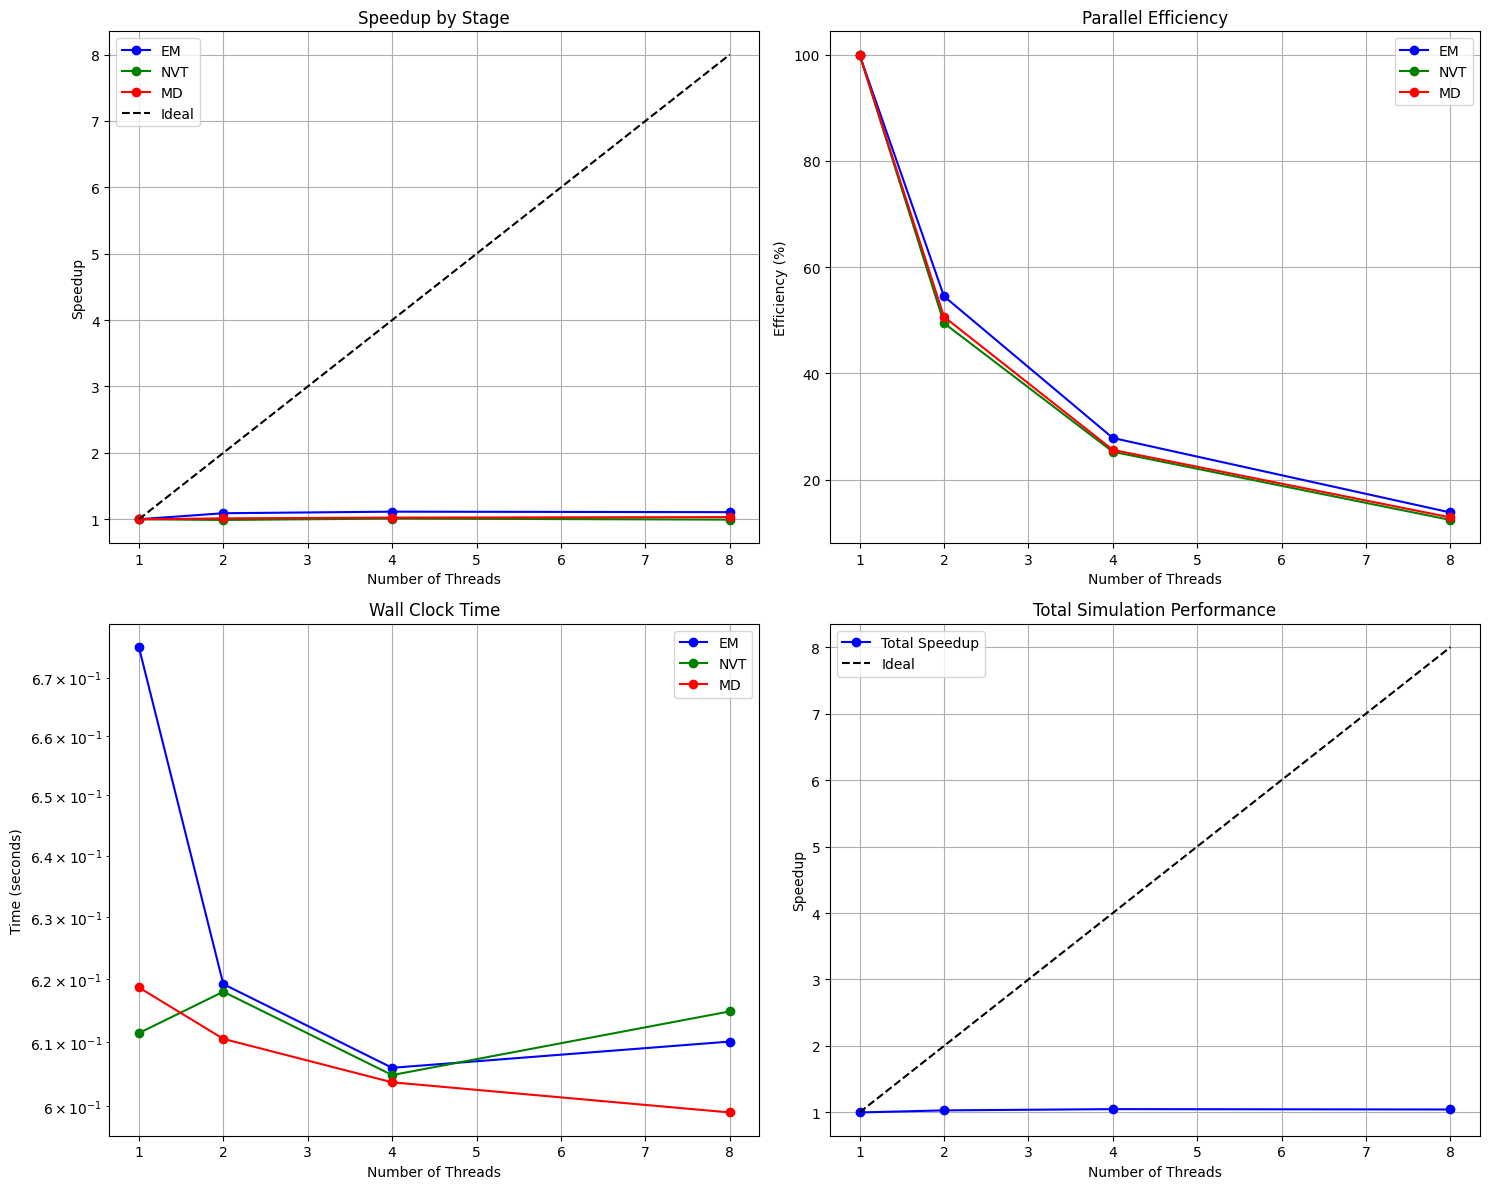


Detailed Performance Analysis:

EM Stage Statistics:
Maximum Speedup: 1.11x
Maximum Efficiency: 100.00%
Time Reduction: 10.26%
Single Thread Time: 0.68 seconds
Best Parallel Time: 0.61 seconds

NVT Stage Statistics:
Maximum Speedup: 1.01x
Maximum Efficiency: 100.00%
Time Reduction: 1.07%
Single Thread Time: 0.61 seconds
Best Parallel Time: 0.60 seconds

MD Stage Statistics:
Maximum Speedup: 1.03x
Maximum Efficiency: 100.00%
Time Reduction: 3.17%
Single Thread Time: 0.62 seconds
Best Parallel Time: 0.60 seconds

Total Simulation Statistics:
Total Single Thread Time: 1.91 seconds
Total Best Parallel Time: 1.81 seconds
Overall Speedup: 1.05x
Total Time Reduction: 4.76%

Detailed results:


In [3]:
try:
    # Initialize simulation
    md_sim = MDSimulation("../data/input")
    
    # Setup parameters
    md_sim.setup_md_parameters()
    
    # Run benchmarks
    md_sim.run_benchmarks()
    
    # Analyze results (only on rank 0)
    if md_sim.rank == 0:
        results = md_sim.analyze_performance()
        print("\nDetailed results:")
        
except Exception as e:
    print(f"Error on rank {md_sim.rank}: {str(e)}")
    
# Finalize MPI
MPI.Finalize()

In [4]:
results

,Stage,Single_Thread_Time,Best_Parallel_Time,Max_Speedup,Best_Thread_Count
0,em,0.614838,0.614680,1.000257,8
1,nvt,0.621805,0.615515,1.010219,8
2,md,0.616463,0.616463,1.000000,1
3,Total,1.853106,1.853106,1.000000,1
